In [3]:
# imports and stuff
import numpy as np
from skimage import io
from glob import glob
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import confusion_matrix
import random
import itertools
# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# Torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torch.optim.lr_scheduler
import torch.nn.init
from torch.autograd import Variable
from scipy import sparse

In [4]:
# Parameters
WINDOW_SIZE = (288, 288) # Patch size
STRIDE = 32 # Stride for testing
BANDS = {'1': 60, '2': 10, '3': 10, '4': 10, '5': 20, '6': 20,
         '7': 20, '8': 10, '8A': 20, '9': 60, '10': 60, '11': 20, '12': 20}
RGB_BANDS = (3,2,1)

#BANDS = {'2': 10, '3': 10, '4': 10, '8': 10}
TCI = False
IN_CHANNELS = len(BANDS)
PRETRAINED = False
FOLDER = "./ISPRS_dataset/" # Replace with your "/path/to/the/ISPRS/dataset/folder/"
BATCH_SIZE = 10 # Number of samples in a mini-batch

LABEL_DETAILS = [('No data', (0,0,0)),
          ('Tree cover areas', (0,160,0)),
          ('Shrubs cover areas', (150,100,0)),
          ('Grassland', (255,180,0)),
          ('Cropland', (255,255,100)),
          ('Vegetation aquatic or regularly flooded', (0,220,130)),
          ('Lichens Mosses / Sparse vegetation', (255,235,175)),
          ('Bare areas',(255,245,215)),
          ('Built up areas',(195,20,0)),
          ('Snow and/or Ice',(255,255,255)),
          ('Open Water',(0,70,200)),
          ('Cloud', (175,175,175))]

LABELS = [l[0] for l in LABEL_DETAILS]
N_CLASSES = len(LABELS) # Number of classes
WEIGHTS = torch.ones(N_CLASSES) # Weights for class balancing
WEIGHTS[0] = 0.
CACHE = True # Store the dataset in-memory

DATASET = '../east_africa.txt'

In [5]:
palette = {v: k[1] for v,k in enumerate(LABEL_DETAILS)}

invert_palette = {v: k for k, v in palette.items()}

def normalize(img):
    img[img > 0.2] = 0.2
    img *= 5
    return img

def bounding_box(mask):
    # Find rows containing at least a True
    rows = np.any(mask, axis=1)
    # Find columns containing at least a True
    cols = np.any(mask, axis=0)
    x_min, x_max = np.where(rows)[0][[0, -1]]
    y_min, y_max = np.where(cols)[0][[0, -1]]
    return x_min, y_min, x_max, y_max


def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    for c, i in palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
        arr_2d[m] = i

    return arr_2d

from s2reader import s2reader as s2
import math

def rowcol(x, y, affine, op=math.floor):
    """ Get row/col for a x/y
    """
    r = int(op((y - affine.f) / affine.e))
    c = int(op((x - affine.c) / affine.a))
    return r, c
def bounds_window(bounds, affine):
    """Create a full cover rasterio-style window
    """
    w, s, e, n = bounds
    row_start, col_start = rowcol(w, n, affine)
    row_stop, col_stop = rowcol(e, s, affine, op=math.ceil)
    return (row_start, row_stop), (col_start, col_stop)

In [6]:
import pyproj
from shapely.geometry import Polygon
from functools import partial

def project_bbox(crs_in, crs_out, bounds):
    """
        Project a bounding box from a CRS to another

        :param crs_in: an input CoordinateReferenceSystem
        :param crs_out: the target CoordinateReferenceSystem
        :param bounds: a tuple of bounds (xmin, ymin, xmax, ymax)
        :param return: the tuple of projected bounds
    """
    xmin, ymin, xmax, ymax = bounds
    bbox = [(xmin,ymin), (xmin, ymax), (xmax, ymax), (xmax, ymin)]
    transform = partial(pyproj.transform, pyproj.Proj(crs_in), pyproj.Proj(crs_out))
    new_coords = []
    for x1, y1 in bbox:
        x2, y2 = transform(x1, y1)
        new_coords.append((x2, y2))
    return Polygon(new_coords).bounds

def get_rgb(data):
    return normalize(np.transpose(data[RGB_BANDS,:,:],(1,2,0)))

In [7]:
with open(DATASET) as f:
    urls = [p.replace('\n','') for p in f.readlines()]

In [8]:
import rasterio

In [9]:
# Utils

def _get_random_pos(img_shape, window_shape):
    w, h = window_shape
    W, H = img_shape
    x1 = random.randint(0, W - w - 1)
    x2 = x1 + w
    y1 = random.randint(0, H - h - 1)
    y2 = y1 + h
    return x1, x2, y1, y2

def get_random_pos(img_shape, window_shape, mask=None):
    """ Extract of 2D random patch of shape window_shape in the image """
    if mask is None:
        return _get_random_pos(img_shape, window_shape)
    else:
        x1, x2, y1, y2 = _get_random_pos(img_shape, window_shape)
        while np.count_nonzero(mask[x1:x2,y1:y2]) < 0.8 * mask[x1:x2,y1:y2].size:
            x1, x2, y1, y2 = _get_random_pos(img_shape, window_shape)
    return x1, x2, y1, y2

def accuracy(input, target):
    return 100 * float(np.count_nonzero(input == target)) / target.size

def sliding_window(top, step=10, window_size=(20,20)):
    """ Slide a window_shape window across the image with a stride of step """
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            yield x, y, window_size[0], window_size[1]
            
def count_sliding_window(top, step=10, window_size=(20,20)):
    """ Count the number of windows in an image """
    c = 0
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            c += 1
    return c

def grouper(n, iterable):
    """ Browse an iterator by chunk of n elements """
    it = iter(iterable)
    while True:
        chunk = tuple(itertools.islice(it, n))
        if not chunk:
            return
        yield chunk

def metrics(predictions, gts, label_values=LABELS):
    cm = confusion_matrix(
            gts,
            predictions,
            range(len(label_values)))
    
    print("Confusion matrix :")
    print(cm)
    
    print("---")
    
    # Compute global accuracy
    total = sum(sum(cm))
    accuracy = sum([cm[x][x] for x in range(len(cm))])
    accuracy *= 100 / float(total)
    print("{} pixels processed".format(total))
    print("Total accuracy : {}%".format(accuracy))
    
    print("---")
    
    # Compute F1 score
    F1Score = np.zeros(len(label_values))
    for i in range(len(label_values)):
        try:
            F1Score[i] = 2. * cm[i,i] / (np.sum(cm[i,:]) + np.sum(cm[:,i]))
        except:
            # Ignore exception if there is no element in class i for test set
            pass
    print("F1Score :")
    for l_id, score in enumerate(F1Score):
        print("{}: {}".format(label_values[l_id], score))

    print("---")
        
    # Compute kappa coefficient
    total = np.sum(cm)
    pa = np.trace(cm) / float(total)
    pe = np.sum(np.sum(cm, axis=0) * np.sum(cm, axis=1)) / float(total*total)
    kappa = (pa - pe) / (1 - pe);
    print("Kappa: " + str(kappa))
    return accuracy

In [10]:
from shapely.ops import transform
import rasterio.features
from skimage.transform import resize

In [11]:
from IPython.core.debugger import set_trace

In [12]:
# Dataset class
class S2CCI_dataset(torch.utils.data.Dataset):
    __data_cache = []
    __cache_renewal = 0.005
    __cache_size = 10
    
    def __init__(self, data_files, ground_truth, bands=BANDS, tci=False, window_size=WINDOW_SIZE, cache=True):
        super(S2CCI_dataset, self).__init__()
        self.cci = rasterio.open(ground_truth)
        self.tci = tci
        self.bands = bands
        self.window_size = window_size
        self.data_files = []
        self.__preload(data_files)
        self.cache = cache
        if cache:
            while len(self.__data_cache) < self.__cache_size:
                self.__data_cache.append(self.load_random())
    
    def __del__(self):
        self.cci.close()
    
    def __len__(self):
        # Default epoch size is 10 000 samples
        return 10000
    
    def __preload(self, data_files):
        self.data_files = []
        for f in tqdm(data_files):
            try:
                with s2.open(f) as product:
                    print(product.path)
                    #shape = rasterio.open(product.granule_paths(2)[0]).shape
                    for granule in product.granules:
                        if self.tci and granule.tci_path is None:
                            print("Skipping because no TCI is available")
                            continue
                        d = granule.__dict__
                        d['shape'] = (10980, 10980) # S2 tile shape at 10m/px
                        d['bands'] = [product.granule_paths(b)[0] for b in self.bands.keys()]
                        #cci_win, nodata_mask = S2CCI_dataset.get_cci(product, self.cci), S2CCI_dataset.get_nodata(product)
                        #self._cache[granule.granule_path] = (cci_win, nodata_mask)
                        self.data_files.append(d)
            except Exception as e:
                print(e)
                pass
        print("Loaded {} data files".format(len(self.data_files)))
    
    @staticmethod
    def get_nodata(product):
        nodata_mask = product.granules[0].nodata_mask
        # Open band 1 (60m, to choose the coordinates)
        with rasterio.Env(GDAL_CACHEMAX=0) as env, rasterio.open(product.granule_paths(1)[0]) as b1:
            project = partial(
                pyproj.transform,
                pyproj.Proj(init='epsg:4326'), # source coordinate system
                pyproj.Proj(init=b1.crs['init'])) # destination coordinate system
            if isinstance(nodata_mask, Polygon) and nodata_mask.is_empty:
                nodata_mask = np.zeros(b1.shape, dtype='bool')
            else:
                projected_nodata = transform(project,nodata_mask)
                if isinstance(nodata_mask, Polygon):
                    projected_nodata = [projected_nodata]
                nodata_mask = rasterio.features.rasterize(projected_nodata, out_shape=b1.shape, transform=b1.transform,fill=0)
                nodata_mask = nodata_mask.astype('bool')
            nodata_mask[b1.read()[0] == 0] = True
        return nodata_mask
    
    @staticmethod
    def get_cci(product, cci):
        print("Generating cloud mask")
        try:
            cloud_mask = product.granules[0].cloudmask
        except AttributeError:
            cloud_mask = None
        # Open band 5 (20m, to generate cloud mask)
        with rasterio.Env(GDAL_CACHEMAX=0) as env, rasterio.open(product.granule_paths(5)[0]) as b5:
            project = partial(
                pyproj.transform,
                pyproj.Proj(init='epsg:4326'), # source coordinate system
                pyproj.Proj(init=b5.crs['init'])) # destination coordinate system
            if cloud_mask is None or (isinstance(cloud_mask, Polygon) and cloud_mask.is_empty): # Empty polygon
                cloud_mask = np.zeros(b5.shape)
            else: # Polygon or Multipolygon
                projected_cm = transform(project, cloud_mask)
                if isinstance(cloud_mask, Polygon):
                    projected_cm = [projected_cm]
                cloud_mask = rasterio.features.rasterize(projected_cm, out_shape=b5.shape, transform=b5.transform,fill=0)
            print("Done")
            cci_crop_coord = project_bbox(b5.crs, cci.crs, b5.bounds)
            print(cci_crop_coord)
            cci_win = cci.read(window=bounds_window(cci_crop_coord, cci.affine))[0]
            print("CCI window : {}".format(cci_win))
            print(cci_win.shape, cloud_mask.shape)
            cci_win = resize(cci_win, cloud_mask.shape, order=0, preserve_range=True).astype('uint8')
            print(cci_win.shape, cloud_mask.shape)
            cci_win[cloud_mask > 0] = 11
            cci_win[cci_win > 11] = 0
            #plt.imshow(cloud_mask > 0) and plt.show()
            print("CCI window with clouds: {}".format(cci_win))
        return cci_win
    
    def load_random(self):
        res = self.__load_random()
        while res is None:
            res = self.__load_random()
        return res
    
    def __load_random(self):
        # Pick a random image
        rand_idx = random.randint(0, len(self.data_files) - 1)
        random_granule = self.data_files[rand_idx]
        random_path = random_granule['granule_path']
        print("Looking into " + random_path)
        
        try:
            with random_granule['dataset'] as product:
                cci_win, nodata_mask = S2CCI_dataset.get_cci(product, self.cci), S2CCI_dataset.get_nodata(product)
                nodata_mask = resize(nodata_mask, cci_win.shape[:2], preserve_range=True, order=0).astype('bool')
                x1, y1, x2, y2 = bounding_box(~nodata_mask)
                cci_win = cci_win[x1:x2, y1:y2]
                nodata_mask = nodata_mask[x1:x2, y1:y2]
                cci_win[nodata_mask] = 0
                if np.count_nonzero(cci_win) - np.count_nonzero(cci_win == 11) < 0.5*cci_win.size:
                    raise Exception('Not enough data')

                if self.tci: # Use true color image only
                    print("Loading band TCI")
                    x_min, x_max, y_min, y_max = map(lambda x: x * 20 // 10, (x1,x2,y1,y2))
                    print(product.granules[0].tci_path)
                    with rasterio.Env(GDAL_CACHEMAX=0) as env, rasterio.open(product.granules[0].tci_path) as raster:
                        data_window = raster.read(window=((x_min, x_max), (y_min, y_max)))
                else:
                    x_min, x_max, y_min, y_max = map(lambda x: x * 20 // 10, (x1,x2,y1,y2))
                    w, h = x_max-x_min, y_max-y_min
                    data_window = np.zeros((len(self.bands), w, h), dtype='uint16')
                    for idx, (band, resolution) in enumerate(self.bands.items()):
                        print("Loading band {}".format(band))
                        #import ipdb; ipdb.set_trace()
                        x_min, x_max, y_min, y_max = map(lambda x: x * 20 // resolution, (x1,x2,y1,y2))
                        print(x_min, x_max, y_min, y_max)
                        with rasterio.Env(GDAL_CACHEMAX=0) as env, rasterio.open(product.granule_paths(band)[0]) as raster:
                            data_window[idx] = resize(raster.read(window=((x_min, x_max), (y_min, y_max)))[0], (w,h), order=0, preserve_range=True).astype('uint16', copy=False)
        except Exception as e:
            print(e)
            self.data_files.remove(random_granule)
            return None
        return data_window.astype('uint16', copy=False), cci_win.astype('uint8', copy=False)
    
    def __getitem__(self, i):

        if self.cache:
            random_idx = random.randint(0, len(self.__data_cache) - 1)
            if random.random() < self.__cache_renewal: # % chance of replacing the data
                print("Replacing from cache")
                del(self.__data_cache[random_idx])
                data, label = self.load_random()
                self.__data_cache.append((data, label))
            else: # else just use what's in the cache
                data, label = self.__data_cache[random_idx]
        else:
            data, label = self.load_random()

        # Get a random patch
        w, h = self.window_size
        x1, x2, y1, y2 = get_random_pos(label.shape, (w//2, h//2), mask=label)
        label_p = label[x1:x2,y1:y2]
        data_p = data[:, 2*x1:2*x2,2*y1:2*y2].astype('float32')
        data_p /= 10000

        # Data augmentation
        #data_p, label_p = self.data_augmentation(data_p, label_p)

        # Return the torch.Tensor values
        return (torch.from_numpy(data_p).float(),
                torch.from_numpy(label_p).long())

In [13]:
class SegNet(nn.Module):
    # SegNet network
    @staticmethod
    def weight_init(m):
        if isinstance(m, (nn.Linear, nn.Conv2d)):
            torch.nn.init.kaiming_normal(m.weight.data)
    
    def __init__(self, in_channels=IN_CHANNELS, out_channels=N_CLASSES):
        super(SegNet, self).__init__()
        self.pool = nn.MaxPool2d(2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(2)
        
        self.conv1_1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.conv1_1_bn = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv1_2_bn = nn.BatchNorm2d(64)
        
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2_1_bn = nn.BatchNorm2d(128)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv2_2_bn = nn.BatchNorm2d(128)
        
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3_1_bn = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_2_bn = nn.BatchNorm2d(256)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_3_bn = nn.BatchNorm2d(256)
        
        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4_1_bn = nn.BatchNorm2d(512)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_2_bn = nn.BatchNorm2d(512)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_3_bn = nn.BatchNorm2d(512)
        
        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_1_bn = nn.BatchNorm2d(512)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_2_bn = nn.BatchNorm2d(512)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_3_bn = nn.BatchNorm2d(512)
        
        self.conv5_3_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_3_D_bn = nn.BatchNorm2d(512)
        self.conv5_2_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_2_D_bn = nn.BatchNorm2d(512)
        self.conv5_1_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_1_D_bn = nn.BatchNorm2d(512)
        
        self.conv4_3_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_3_D_bn = nn.BatchNorm2d(512)
        self.conv4_2_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_2_D_bn = nn.BatchNorm2d(512)
        self.conv4_1_D = nn.Conv2d(512, 256, 3, padding=1)
        self.conv4_1_D_bn = nn.BatchNorm2d(256)
        
        self.conv3_3_D = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_3_D_bn = nn.BatchNorm2d(256)
        self.conv3_2_D = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_2_D_bn = nn.BatchNorm2d(256)
        self.conv3_1_D = nn.Conv2d(256, 128, 3, padding=1)
        self.conv3_1_D_bn = nn.BatchNorm2d(128)
        
        self.conv2_2_D = nn.Conv2d(128, 128, 3, padding=1)
        self.conv2_2_D_bn = nn.BatchNorm2d(128)
        self.conv2_1_D = nn.Conv2d(128, 64, 3, padding=1)
        self.conv2_1_D_bn = nn.BatchNorm2d(64)
        
        self.conv1_2_D = nn.Conv2d(64, 64, 3, padding=1)
        self.conv1_2_D_bn = nn.BatchNorm2d(64)
        self.conv1_1_D = nn.Conv2d(64, out_channels, 3, padding=1)
        
        self.apply(self.weight_init)
        
    def forward(self, x):
        # Encoder block 1
        x = self.conv1_1_bn(F.relu(self.conv1_1(x)))
        x = self.conv1_2_bn(F.relu(self.conv1_2(x)))
        x, mask1 = self.pool(x)
        
        # Encoder block 2
        x = self.conv2_1_bn(F.relu(self.conv2_1(x)))
        x = self.conv2_2_bn(F.relu(self.conv2_2(x)))
        x, mask2 = self.pool(x)
        
        # Encoder block 3
        x = self.conv3_1_bn(F.relu(self.conv3_1(x)))
        x = self.conv3_2_bn(F.relu(self.conv3_2(x)))
        x = self.conv3_3_bn(F.relu(self.conv3_3(x)))
        x, mask3 = self.pool(x)
        
        # Encoder block 4
        x = self.conv4_1_bn(F.relu(self.conv4_1(x)))
        x = self.conv4_2_bn(F.relu(self.conv4_2(x)))
        x = self.conv4_3_bn(F.relu(self.conv4_3(x)))
        x, mask4 = self.pool(x)
        
        # Encoder block 5
        x = self.conv5_1_bn(F.relu(self.conv5_1(x)))
        x = self.conv5_2_bn(F.relu(self.conv5_2(x)))
        x = self.conv5_3_bn(F.relu(self.conv5_3(x)))
        x, mask5 = self.pool(x)
        
        # Decoder block 5
        x = self.unpool(x, mask5)
        x = self.conv5_3_D_bn(F.relu(self.conv5_3_D(x)))
        x = self.conv5_2_D_bn(F.relu(self.conv5_2_D(x)))
        x = self.conv5_1_D_bn(F.relu(self.conv5_1_D(x)))
        
        # Decoder block 4
        x = self.unpool(x, mask4)
        x = self.conv4_3_D_bn(F.relu(self.conv4_3_D(x)))
        x = self.conv4_2_D_bn(F.relu(self.conv4_2_D(x)))
        x = self.conv4_1_D_bn(F.relu(self.conv4_1_D(x)))
        
        # Decoder block 3
        x = self.unpool(x, mask3)
        x = self.conv3_3_D_bn(F.relu(self.conv3_3_D(x)))
        x = self.conv3_2_D_bn(F.relu(self.conv3_2_D(x)))
        x = self.conv3_1_D_bn(F.relu(self.conv3_1_D(x)))
        
        # Decoder block 2
        x = self.unpool(x, mask2)
        x = self.conv2_2_D_bn(F.relu(self.conv2_2_D(x)))
        x = self.conv2_1_D_bn(F.relu(self.conv2_1_D(x)))
        
        # Decoder block 1
        #x = self.unpool(x, mask1)
        x = self.conv1_2_D_bn(F.relu(self.conv1_2_D(x)))
        x = self.conv1_1_D(x)
        return x

In [14]:
# instantiate the network
net = SegNet()

/home/naudebert/.anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  


We download and load the pre-trained weights from VGG-16 on ImageNet. This step is optional but it makes the network converge faster. We skip the weights from VGG-16 that have no counterpart in SegNet.

In [15]:
if PRETRAINED:
    import os
    try:
        from urllib.request import URLopener
    except ImportError:
        from urllib import URLopener

    # Download VGG-16 weights from PyTorch
    vgg_url = 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth'
    if not os.path.isfile('./vgg16_bn-6c64b313.pth'):
        weights = URLopener().retrieve(vgg_url, './vgg16_bn-6c64b313.pth')

    vgg16_weights = torch.load('./vgg16_bn-6c64b313.pth')
    mapped_weights = {}
    for k_vgg, k_segnet in zip(vgg16_weights.keys(), net.state_dict().keys()):
        if "features" in k_vgg:
            mapped_weights[k_segnet] = vgg16_weights[k_vgg]
            print("Mapping {} to {}".format(k_vgg, k_segnet))

    try:
        net.load_state_dict(mapped_weights)
        print("Loaded VGG-16 weights in SegNet !")
    except:
        # Ignore missing keys
        pass

Then, we load the network on GPU.

In [16]:
net.cuda()

SegNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (conv1_1): Conv2d(13, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1_bn): BatchNorm2d(256, eps=1e-05, mo

In [15]:
print(urls[:2])

['/home/naudebert/east_africa/S2A_OPER_PRD_MSIL1C_PDMC_20151217T142523_R106_V20151217T073600_20151217T073600.SAFE', '/home/naudebert/east_africa/S2A_OPER_PRD_MSIL1C_PDMC_20151218T170746_R121_V20151218T084420_20151218T084420.SAFE']


In [16]:
train_set = S2CCI_dataset(urls, '../ESA_CCI_African_LandCover_20m/ESACCI-LC-L4-LC10-Map-20m-P1Y-2016-v1.0.tif')
train_loader = torch.utils.data.DataLoader(train_set,batch_size=BATCH_SIZE, num_workers=0)

/home/naudebert/east_africa/S2A_OPER_PRD_MSIL1C_PDMC_20151217T142523_R106_V20151217T073600_20151217T073600.SAFE
/home/naudebert/east_africa/S2A_OPER_PRD_MSIL1C_PDMC_20151218T170746_R121_V20151218T084420_20151218T084420.SAFE



KeyboardInterrupt: 

### Designing the optimizer

We use the standard Stochastic Gradient Descent algorithm to optimize the network's weights.

The encoder is trained at half the learning rate of the decoder, as we rely on the pre-trained VGG-16 weights. We use the ``torch.optim.lr_scheduler`` to reduce the learning rate by 10 after 25, 35 and 45 epochs.

In [17]:
base_lr = 0.01
params_dict = dict(net.named_parameters())
params = []
for key, value in params_dict.items():
    if '_D' in key:
        # Decoder weights are trained at the nominal learning rate
        params += [{'params':[value],'lr': base_lr}]
    else:
        # Encoder weights are trained at lr / 2 (we have VGG-16 weights as initialization)
        params += [{'params':[value],'lr': base_lr / 2}]

optimizer = optim.SGD(net.parameters(), lr=base_lr, momentum=0.9, weight_decay=0.0005)
#optimizer = optim.Adam(net.parameters(), lr=base_lr, weight_decay=0.0005, amsgrad=True)
# We define the scheduler
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [100, 150], gamma=0.1)
#scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [50, 75, 90], gamma=0.1)

In [18]:
from IPython.display import clear_output

def train(net, optimizer, epochs, scheduler=None, weights=WEIGHTS, save_epoch = 5):
    losses = np.zeros(1000000)
    mean_losses = np.zeros(1000000)
    weights = weights.cuda()
    iter_ = 0
    
    for e in range(1, epochs + 1):
        if scheduler is not None:
            scheduler.step()
        net.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = Variable(data.cuda()), Variable(target.cuda())
            optimizer.zero_grad()
            output = net(data)
            loss = F.cross_entropy(output, target, weight=weights)
            loss.backward()
            optimizer.step()
            
            losses[iter_] = loss.item()
            mean_losses[iter_] = np.mean(losses[max(0,iter_-100):iter_])
            
            if iter_ % 100 == 0:
                clear_output()
                rgb = get_rgb(data.cpu().numpy()[0])
                pred = np.argmax(output.data.cpu().numpy()[0], axis=0)
                gt = target.data.cpu().numpy()[0]
                print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}'.format(
                    e, epochs, batch_idx, len(train_loader),
                    100. * batch_idx / len(train_loader), loss.data[0], accuracy(pred, gt)))
                plt.plot(mean_losses[:iter_]) and plt.show()
                fig = plt.figure()
                fig.add_subplot(131)
                plt.imshow(rgb)
                plt.title('RGB')
                fig.add_subplot(132)
                plt.imshow(convert_to_color(gt))
                plt.title('Ground truth')
                fig.add_subplot(133)
                plt.title('Prediction')
                plt.imshow(convert_to_color(pred))
                plt.show()
            iter_ += 1
            
            del(data, target, loss)
            
        if e % save_epoch == 0:
            # We validate with the largest possible stride for faster computing
            #acc = test(net, test_ids, all=False, stride=min(WINDOW_SIZE))
            acc = 0.
            torch.save(net.state_dict(), './segnet256_epoch{}_{}'.format(e, acc))
    torch.save(net.state_dict(), './segnet_final')

### Training the network

Let's train the network for 50 epochs. The `matplotlib` graph is periodically udpated with the loss plot and a sample inference. Depending on your GPU, this might take from a few hours (Titan Pascal) to a full day (old K20).

Train (epoch 1/200) [300/1000 (30%)]	Loss: 0.911221	Accuracy: 95.93942901234568


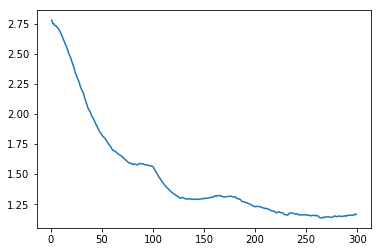

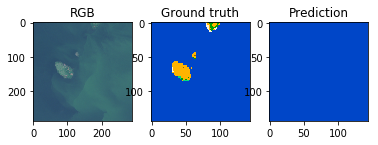

Replacing from cache
Looking into /home/naudebert/east_africa/S2A_OPER_PRD_MSIL1C_PDMC_20151223T021840_R035_V20151222T081758_20151222T081758.SAFE/GRANULE/S2A_OPER_MSI_L1C_TL_MTI__20151222T101055_A002606_T37PBP_N02.01
Generating cloud mask
Done
(32.999816437010196, 10.765404630173208, 34.00752284452154, 11.760044027808236)
CCI window : [[4 4 4 ... 3 3 3]
 [4 4 4 ... 3 3 3]
 [4 4 4 ... 3 3 3]
 ...
 [3 3 3 ... 2 2 3]
 [3 3 3 ... 2 2 2]
 [3 3 3 ... 2 2 2]]
(5372, 5443) (5490, 5490)
(5490, 5490) (5490, 5490)
CCI window with clouds: [[4 4 4 ... 3 3 3]
 [4 4 4 ... 3 3 3]
 [4 4 4 ... 3 3 3]
 ...
 [3 3 3 ... 2 2 3]
 [3 3 3 ... 2 2 2]
 [3 3 3 ... 2 2 2]]
Loading band 1
0 1829 912 1829
Loading band 2
0 10978 5472 10978
Loading band 3
0 10978 5472 10978
Loading band 4
0 10978 5472 10978
Loading band 5
0 5489 2736 5489
Loading band 6
0 5489 2736 5489
Loading band 7
0 5489 2736 5489
Loading band 8
0 10978 5472 10978
Loading band 8A
0 5489 2736 5489
Loading band 9
0 1829 912 1829
Loading band 10
0 18

(5490, 5490) (5490, 5490)
CCI window with clouds: [[1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 ...
 [3 3 3 ... 4 4 4]
 [3 3 3 ... 4 4 4]
 [3 3 3 ... 4 4 4]]
Loading band 1
0 1829 946 1829
Loading band 2
0 10978 5676 10978
Loading band 3
0 10978 5676 10978
Loading band 4
0 10978 5676 10978
Loading band 5
0 5489 2838 5489
Loading band 6
0 5489 2838 5489
Loading band 7
0 5489 2838 5489
Loading band 8
0 10978 5676 10978
Loading band 8A
0 5489 2838 5489
Loading band 9
0 1829 946 1829
Loading band 10
0 1829 946 1829
Loading band 11
0 5489 2838 5489
Loading band 12
0 5489 2838 5489
Replacing from cache
Looking into /home/naudebert/east_africa/S2A_OPER_PRD_MSIL1C_PDMC_20151229T153334_R135_V20151229T081422_20151229T081422.SAFE/GRANULE/S2A_OPER_MSI_L1C_TL_SGS__20151229T114601_A002706_T36MWE_N02.01
Generating cloud mask
Done
(32.99982005124601, -2.8026544009499745, 33.987689344391114, -1.8090056811827624)
CCI window : [[10 10 10 ...  4  4  2]
 [10 10 10 ...  4  4  2]
 [10 10 10 ...  

In [ ]:
train(net, optimizer, 200, scheduler)

In [ ]:
d = S2CCI_dataset.__dict__['_S2CCI_dataset__data_cache']
print(len(d))

In [20]:
print(len(train_set.data_files))

299


In [19]:
net.load_state_dict(torch.load('./segnet256_epoch155_0.0'))

In [20]:
def test(net, products, cci, stride=WINDOW_SIZE[0]//2, bands=BANDS, batch_size=BATCH_SIZE, window_size=WINDOW_SIZE):  
    # Switch the network to inference mode
    net.eval()
    with torch.no_grad():
        for i, product in enumerate(products):
            try:
                product = s2.open(product)
                cci_win, nodata_mask = S2CCI_dataset.get_cci(product, cci), S2CCI_dataset.get_nodata(product)
                nodata_mask = resize(nodata_mask, cci_win.shape[:2], preserve_range=True, order=0).astype('bool')
                x1, y1, x2, y2 = bounding_box(~nodata_mask)
                cci_win = cci_win[x1:x2, y1:y2]
                nodata_mask = nodata_mask[x1:x2, y1:y2]
                cci_win[nodata_mask] = 0
                if np.count_nonzero(cci_win) - np.count_nonzero(cci_win == 11) < 0.5*cci_win.size:
                    raise Exception('Not enough data')

                if TCI: # Use true color image only
                    print("Loading band TCI")
                    x_min, x_max, y_min, y_max = map(lambda x: x * 20 // 10, (x1,x2,y1,y2))
                    print(product.granules[0].tci_path)
                    data_window = rasterio.open(product.granules[0].tci_path).read(window=((x_min, x_max), (y_min, y_max)))
                else:
                    x_min, x_max, y_min, y_max = map(lambda x: x * 20 // 10, (x1,x2,y1,y2))
                    w, h = x_max-x_min, y_max-y_min
                    data_window = np.zeros((len(bands), w, h), dtype='float32')
                    for idx, (band, resolution) in enumerate(bands.items()):
                        print("Loading band {}".format(band))
                        x_min, x_max, y_min, y_max = map(lambda x: x * 20 // resolution, (x1,x2,y1,y2))
                        print(x_min, x_max, y_min, y_max)
                        raster = rasterio.open(product.granule_paths(band)[0])
                        data_window[idx] = resize(raster.read(window=((x_min, x_max), (y_min, y_max)))[0], (w,h), order=0, preserve_range=True).astype('uint16', copy=False)
                #set_trace()
                img = data_window/10000
                gt = cci_win
                pred = np.zeros(gt.shape + (N_CLASSES,))
                print(img.shape)

                plt.rcParams['figure.figsize'] = (15, 15)

                total = count_sliding_window(img[0], step=stride, window_size=window_size) // batch_size
                for i, coords in enumerate(tqdm(grouper(batch_size, sliding_window(img[0], step=stride, window_size=window_size)), total=total, leave=False)):
                    # Build the tensor
                    image_patches = [np.copy(img[:,x:x+w, y:y+h]) for x,y,w,h in coords]
                    image_patches = np.asarray(image_patches)
                    image_patches = Variable(torch.from_numpy(image_patches).cuda(), volatile=True)

                    # Do the inference
                    outs = net(image_patches)
                    outs = outs.data.cpu().numpy()

                    # Fill in the results array
                    for out, (x, y, w, h) in zip(outs, coords):
                        out = out.transpose((1,2,0))
                        pred[x//2:(x+w)//2, y//2:(y+h)//2] += out
                    del(outs)

                pred = np.argmax(pred, axis=-1)

                # Display the result
                fig = plt.figure()
                fig.add_subplot(1,3,1)
                rgb = get_rgb(img.copy())
                plt.imshow(rgb)
                fig.add_subplot(1,3,2)
                plt.imshow(convert_to_color(pred))
                fig.add_subplot(1,3,3)
                plt.imshow(convert_to_color(gt))
                plt.show()

                # Compute some metrics
                metrics(pred[~nodata_mask].ravel(), gt[~nodata_mask].ravel())
                filename = str(i)
                io.imsave(filename + '_rgb.tif', rgb)
                io.imsave(filename + '_gt.tif', convert_to_color(gt))
                io.imsave(filename + '_pred.tif', convert_to_color(pred))
            except Exception as e:
                print(e)
                pass
    if all:
        return accuracy
    else:
        return accuracy

Generating cloud mask


/home/naudebert/.anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  
/home/naudebert/.anaconda3/lib/python3.6/site-packages/rasterio/features.py:303: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


Done
(32.095365802682714, -6.421506326508901, 33.08826069638461, -5.427550802596051)
CCI window : [[3 1 1 ... 2 2 2]
 [3 1 1 ... 1 1 1]
 [3 3 1 ... 1 1 1]
 ...
 [3 3 3 ... 1 1 1]
 [1 2 2 ... 1 1 1]
 [1 2 2 ... 1 1 1]]
(5369, 5363) (5490, 5490)


/home/naudebert/.anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(5490, 5490) (5490, 5490)
CCI window with clouds: [[3 1 1 ... 2 2 2]
 [3 1 1 ... 1 1 1]
 [3 3 1 ... 1 1 1]
 ...
 [3 3 3 ... 1 1 1]
 [1 2 2 ... 1 1 1]
 [1 2 2 ... 1 1 1]]
Loading band 1
0 1829 0 1013
Loading band 2
0 10978 0 6082
Loading band 3
0 10978 0 6082
Loading band 4
0 10978 0 6082
Loading band 5
0 5489 0 3041
Loading band 6
0 5489 0 3041
Loading band 7
0 5489 0 3041
Loading band 8
0 10978 0 6082
Loading band 8A
0 5489 0 3041
Loading band 9
0 1829 0 1013
Loading band 10
0 1829 0 1013
Loading band 11
0 5489 0 3041
Loading band 12
0 5489 0 3041
(13, 10978, 6082)


/home/naudebert/.anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


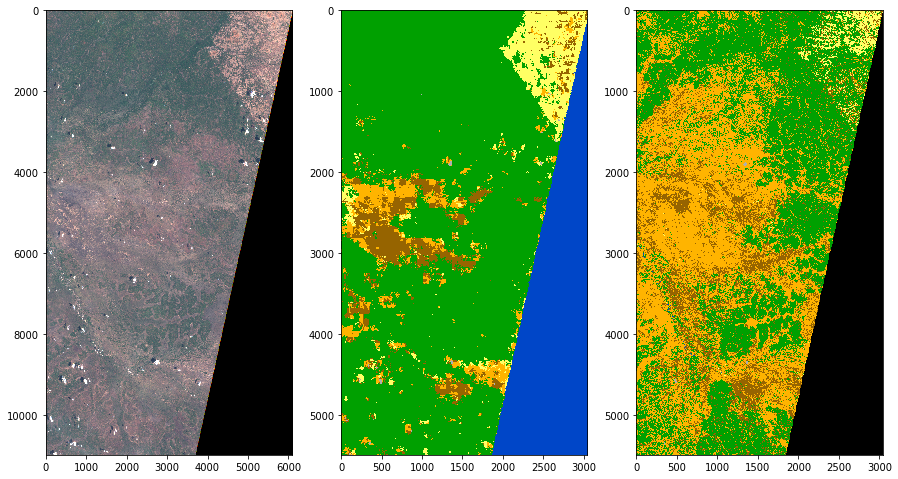

Confusion matrix :
[[      0       0       0       0       0       0       0       0       0
        0       0       0]
 [      0 5147196   76143   75214  444470       0       0       0      22
        0     301    2911]
 [      0 1333089  252698  257285  127425       0       0       0      16
        0      69    1460]
 [      0 4202805  594163  476486  169068       0       0       0       2
        0      93    3010]
 [      0    8654   26196   19206  193659       0       0       0      18
        0      15     164]
 [      0     278       2      87       7       0       0       0       0
        0       0       8]
 [      0      18       0       2      12       0       0       0       0
        0       0       0]
 [      0     134      25      60       6       0       0       0       0
        0       0       0]
 [      0       2       0       1     146       0       0       0       0
        0       0       0]
 [      0       0       0       0       0       0       0       0       

/home/naudebert/.anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in double_scalars


Generating cloud mask
Done
(35.69784549363998, -3.7034039262628853, 36.68768474372165, -2.708535417688948)
CCI window : [[7 3 3 ... 3 1 1]
 [7 7 7 ... 3 3 1]
 [7 7 7 ... 3 1 1]
 ...
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]]
(5373, 5346) (5490, 5490)
(5490, 5490) (5490, 5490)
CCI window with clouds: [[7 3 3 ... 3 1 1]
 [7 7 7 ... 3 3 1]
 [7 7 7 ... 3 1 1]
 ...
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]
 [1 1 1 ... 2 2 2]]
Not enough data
Generating cloud mask
Done
(34.7969157148421, -1.896817942587377, 35.78414747428953, -0.903295103929261)
CCI window : [[4 4 4 ... 1 1 1]
 [4 4 4 ... 1 1 1]
 [4 4 4 ... 1 1 1]
 ...
 [4 3 3 ... 4 4 3]
 [4 4 3 ... 4 4 3]
 [4 4 3 ... 4 4 3]]
(5366, 5332) (5490, 5490)
(5490, 5490) (5490, 5490)
CCI window with clouds: [[4 4 4 ... 1 1 1]
 [4 4 4 ... 1 1 1]
 [4 4 4 ... 1 1 1]
 ...
 [4 3 3 ... 4 4 3]
 [4 4 3 ... 4 4 3]
 [4 4 3 ... 4 4 3]]
Loading band 1
0 1829 0 1829
Loading band 2
0 10978 0 10978
Loading band 3
0 10978 0 10978
Loading band 4
0 10978 

In [ ]:
test_products = (l.replace('\n','') for l in open('../tanzania_s2_paths.txt').readlines()[35:])
test(net, test_products, rasterio.open('../ESA_CCI_African_LandCover_20m/ESACCI-LC-L4-LC10-Map-20m-P1Y-2016-v1.0.tif'))